In [11]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import euclidean

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Rescaling, Conv2D, \
                                    Dropout, MaxPooling2D,\
                                    Flatten, Dense, ReLU, Lambda

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    for gpu_instance in physical_devices: 
        tf.config.experimental.set_memory_growth(gpu_instance, True)
    if len(physical_devices) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))
else:
    print("Sorry, no GPU for you...")

!nvidia-smi

We got a GPU
Mon Feb 12 15:46:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

In [3]:
width = 200
height = 150
channels = 1
input_shape = (height, width, channels)

In [4]:
def load_data():
    X = np.load("/kaggle/input/signatures-numpy-no-split/X.npy")
    print(X.shape)
    y = np.load("/kaggle/input/signatures-numpy-no-split/y.npy")
    print(y.shape)

    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size = 0.3, random_state = None)
    print(X_t.shape)
    print(y_t.shape)
    print(X_test.shape)
    print(y_test.shape)

    del X
    del y

    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size = 0.2, random_state = None)
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)

    del X_t
    del y_t

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data()

(30360, 2, 150, 200)
(30360,)
(21252, 2, 150, 200)
(21252,)
(9108, 2, 150, 200)
(9108,)
(17001, 2, 150, 200)
(17001,)
(4251, 2, 150, 200)
(4251,)


## Data visualization

In [6]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        
        n = random.randint(0, pairs.shape[0])
        print(f"Index to show: {n}")
        ax.imshow(np.concatenate([pairs[n][0], pairs[n][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[n], predictions[n][0]))
        else:
            ax.set_title("Label: {}".format(labels[n]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


### Visualize train data

Index to show: 12722
Index to show: 9141
Index to show: 9000
Index to show: 4224


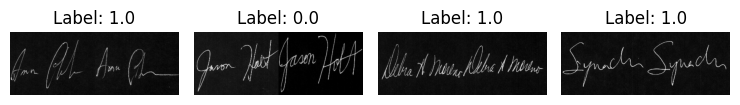

In [7]:
visualize(X_train[:-1], y_train[:-1], to_show = 4, num_col = 4)

Index to show: 3913
Index to show: 771
Index to show: 1308
Index to show: 1561


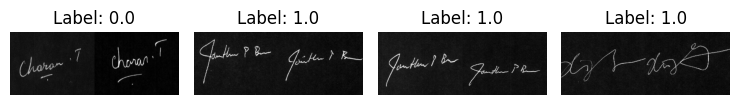

In [8]:
visualize(X_val[:-1], y_val[:-1], to_show = 4, num_col = 4)

### Visualize test data

Index to show: 6727
Index to show: 6013
Index to show: 206
Index to show: 1969


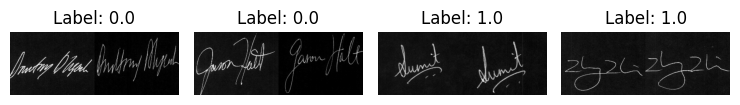

In [9]:
visualize(X_test[:-1], y_test[:-1], to_show = 4, num_col = 4)

## Siamese Network

In [10]:
def siamese_network(input_shape):
    input = Input(input_shape)

    x = Rescaling(1/255)(input)

    x = Conv2D(64, (11, 11), activation = "relu")(input)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)

    x = Conv2D(128, (7, 7), activation = "relu")(x)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), activation = "relu")(x)

    x = Conv2D(512, (3, 3), activation = "relu")(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation = "relu")(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    x = Dense(128, activation = "relu")(x)

    model = Model(input, x)

    return model

def euclidean_distance(vecs):
    (imgA, imgB) = vecs
    sum_square = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [11]:
if len(physical_devices) > 1:
    with strategy.scope():
        imageA = Input(input_shape)
        imageB = Input(input_shape)

        siamese = siamese_network(input_shape)

        modelA = siamese(imageA)
        modelB = siamese(imageB)

        distance = Lambda(euclidean_distance, output_shape=(1,))([modelA, modelB])
        
        output = Dense(1, activation = "sigmoid")(distance)

        model = Model(inputs = [imageA, imageB], outputs = output)

        model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
else:
    imageA = Input(input_shape)
    imageB = Input(input_shape)

    siamese = siamese_network(input_shape)

    modelA = siamese(imageA)
    modelB = siamese(imageB)

    distance = Lambda(euclidean_distance, output_shape=(1,))([modelA, modelB])
    
    output = Dense(1, activation = "sigmoid")(distance)

    model = Model(inputs = [imageA, imageB], outputs = output)

    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 200, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150, 200, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  3530918   ['input_1[0][0]',             
                                                          4          'input_2[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 1)                    0         ['model[0][0]',         

In [ ]:
batch_size = 64
epochs = 20
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1)

history = model.fit([X_train[:, 0, :, :], X_train[:, 1, :, :]], y_train,
                    validation_data = ([X_val[:, 0, :, :], X_val[:, 1, :, :]], y_val),
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1)

Epoch 1/20


2024-02-12 15:50:10.266473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707753018.974895     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/266 [===============>..............] - ETA: 1:23 - loss: 0.1236 - accuracy: 0.0546

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the loss
plt_metric(history=history.history, metric="loss", title="Binary Crossentropy Loss")


In [ ]:
results = model.evaluate([X_test[:, 0, :, :], X_test[:, 1, :, :]], y_test)
print("test loss, test acc:", results)

In [ ]:
predictions = model.predict([X_test[:, 0, :, :], X_test[:, 1, :, :]])
visualize(X_test[:-1], y_test[:-1], to_show=3, predictions=predictions, test=True)

In [ ]:
model.save("/kaggle/working/signatures_siamese_64_512_lrn_bcrloss.keras")

## SVM

In [13]:
pairwise_distances = []

for pairs in X_train[:]:
    #print(pairs.shape)
    image_1_hog = hog(pairs[0])
    #print(image_1_hog.shape)
    image_2_hog = hog(pairs[1])
    #print(image_2_hog.shape)
    distance = euclidean(image_1_hog, image_2_hog)
    #print(distance)
    pairwise_distances.append(distance)

In [23]:
distances_train = np.array(pairwise_distances)
print(pairwise_distances_np.shape)

(17001,)


In [24]:
distances_train = pairwise_distances_np.reshape(-1, 1)
print(distances_train.shape)

(17001, 1)


In [ ]:
distances_val_arr = []

i = 1
for pairs in X_val[:]:
    print(f"Iteration {i}")
    #print(pairs.shape)
    image_1_hog = hog(pairs[0])
    #print(image_1_hog.shape)
    image_2_hog = hog(pairs[1])
    #print(image_2_hog.shape)
    distance = euclidean(image_1_hog, image_2_hog)
    #print(distance)
    distances_val_arr.append(distance)
    i += 1

In [20]:
distances_val = np.array(distances_val_arr)
print(distances_val.shape)

(4251,)


In [21]:
distances_val = distances_val.reshape(-1, 1)
print(distances_val.shape)

(4251, 1)


In [25]:
svm = SVC(kernel = "linear")
svm.fit(distances_train, y_train)

SVC(kernel='linear')

In [26]:
y_pred_val = svm.predict(distances_val)

In [27]:
print("Metrics\n" + classification_report(y_val, y_pred_val))

Metrics
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78      2127
         1.0       0.77      0.81      0.79      2124

    accuracy                           0.79      4251
   macro avg       0.79      0.79      0.79      4251
weighted avg       0.79      0.79      0.79      4251

